# RD performance of the 2D-DWT

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import math
import numpy as np
from scipy import signal
import cv2
import os
import pywt
import pylab
!ln -sf ~/MRVC/src/deadzone.py .
!ln -sf ~/MRVC/src/frame.py .
!ln -sf ~/MRVC/src/YCoCg.py .
!ln -sf ~/MRVC/src/DWT.py .
!ln -sf ~/MRVC/src/distortion.py .
!ln -sf ~/MRVC/src/L_DWT.py
!ln -sf ~/MRVC/src/H_DWT.py
import deadzone as Q
import frame
import YCoCg
import DWT
import distortion

Quantization step = 8
Wavelet = Wavelet db5
  Family name:    Daubechies
  Short name:     db
  Filters length: 10
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False
DWT extension mode = periodization


In [2]:
def q_deq(x, quantization_step):
    k = Q.quantize(x, quantization_step)
    y = Q.dequantize(k, quantization_step)
    return k, y

In [3]:
def read_indexes(prefix):
    frame.read(prefix)
    
def write_indexes(prefix):
    frame.save(prefix)

In [4]:
prefix = "/home/vruiz/MRVC/sequences/stockholm_5_frames/"
RGB_frame = frame.read(prefix, 0)

frame.read(/home/vruiz/MRVC/sequences/stockholm_5_frames/, 0) (768, 1280, 3) uint8 1927590


In [5]:
def show(img, title):
    img = frame.normalize(img)
    plt.figure(figsize=(10,10))
    plt.title(title, fontsize=20)
    plt.imshow(img)

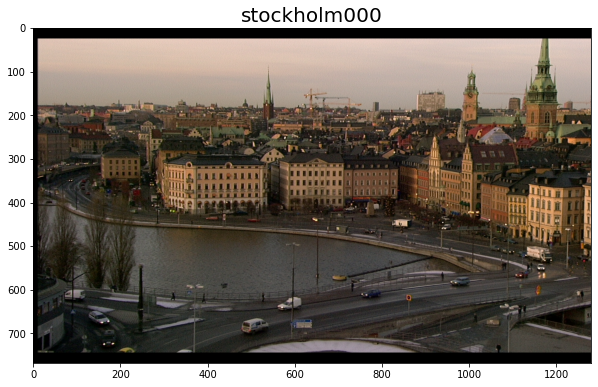

In [6]:
show(RGB_frame, "stockholm000")

### Testing reversebility

In [7]:
RGB_decomposition = DWT.analyze(RGB_frame, n_levels=3)
RGB_reconstructed_frame = DWT.synthesize(RGB_decomposition, n_levels=3)
(RGB_frame == RGB_reconstructed_frame).all()

(768, 1280) (768, 1280, 3)


False

In [8]:
RGB_reconstructed_frame.shape

(768, 1280, 3)

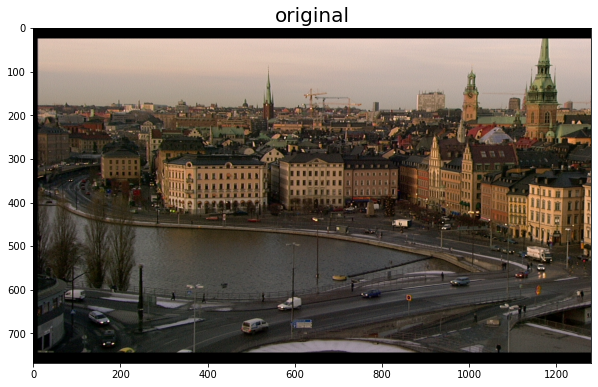

In [9]:
show(RGB_frame, "original")

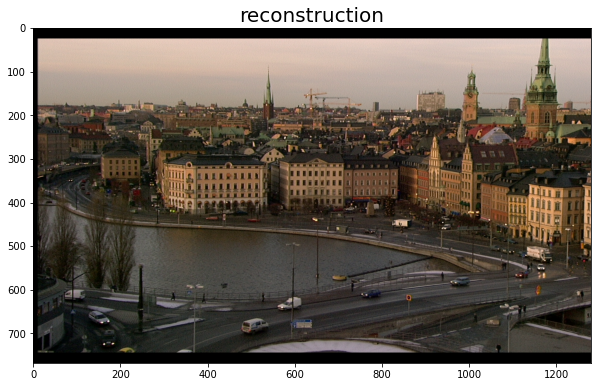

In [10]:
show(RGB_reconstructed_frame, "reconstruction")

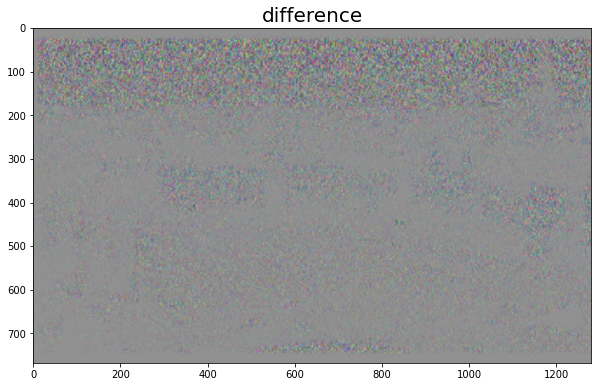

In [11]:
show(RGB_frame - RGB_reconstructed_frame, "difference")

In [12]:
YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
YCoCg_decomposition = DWT.analyze(YCoCg_frame, n_levels=2)
YCoCg_reconstructed_frame = DWT.synthesize(YCoCg_decomposition, n_levels=2)
RGB_reconstructed_frame = YCoCg.to_RGB(YCoCg_reconstructed_frame)
(RGB_frame == RGB_reconstructed_frame).all()

(768, 1280) (768, 1280, 3)


False

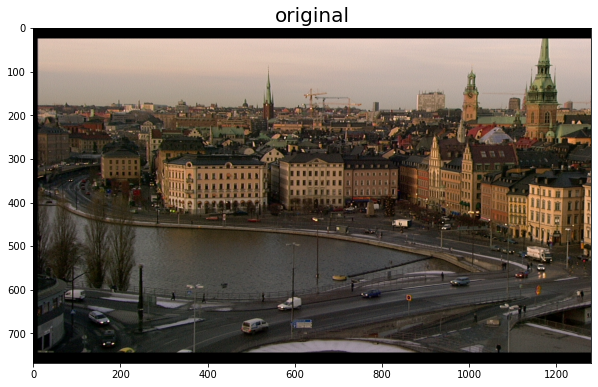

In [13]:
show(RGB_frame, "original") 

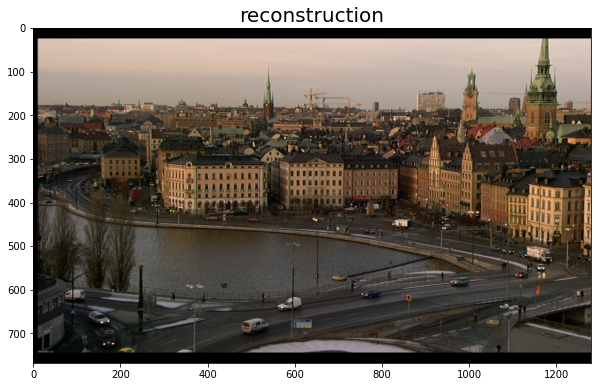

In [14]:
show(RGB_reconstructed_frame, "reconstruction")

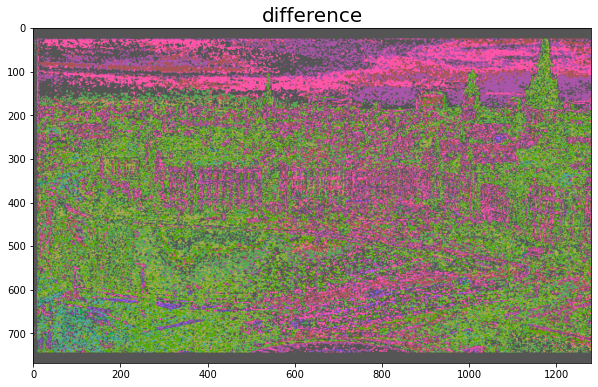

In [15]:
show(RGB_frame - RGB_reconstructed_frame, "difference")

In [16]:
DWT.write(RGB_decomposition, "/tmp/", 0)

L.write(/tmp/3, 0) 2083.8644160406993 -157.54904941605395 (96, 160, 3) float64 58846
H.write(/tmp/3, 0) (96, 160, 3) 475.4919406497475 -445.60651326782374 float64 57363
H.write(/tmp/3, 0) (96, 160, 3) 686.1697168862155 -780.8005420143061 float64 58068
H.write(/tmp/3, 0) (96, 160, 3) 305.134978679282 -291.8543141024762 float64 55211
H.write(/tmp/2, 0) (192, 320, 3) 255.14834343795275 -324.7057614240733 float64 200847
H.write(/tmp/2, 0) (192, 320, 3) 287.4819696910166 -288.12707447419433 float64 213229
H.write(/tmp/2, 0) (192, 320, 3) 139.3014030710445 -134.6719038261092 float64 190233
H.write(/tmp/1, 0) (384, 640, 3) 164.67053320997505 -192.1196807389951 float64 673485
H.write(/tmp/1, 0) (384, 640, 3) 137.25410702759393 -166.97874282708597 float64 739526
H.write(/tmp/1, 0) (384, 640, 3) 54.004601635364885 -45.356403880598656 float64 627186


## Quantizing the RGB domain

In [ ]:
RGB_points = []
with open('../05-quantization/RGB.txt', 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_points.append((float(rate), float(_distortion)))

## Quantizing the YCoCg domain

In [ ]:
YCoCg_points = []
with open('../06-color_transform/YCoCg.txt', 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        YCoCg_points.append((float(rate), float(_distortion)))

## Quantizing the YCoCg/DWT domain

In [ ]:
def bytes_per_frame(img):
    frame.write(img, "/tmp/frame")
    length_in_bytes = os.path.getsize("/tmp/frame.png")
    return length_in_bytes

def bits_per_pixel(img):
    return 8*bytes_per_frame(img)/np.size(img)

def bytes_per_grayframe(img):
    cv2.imwrite("/tmp/frame.png", img)
    length_in_bytes = os.path.getsize("/tmp/frame.png")
    return length_in_bytes

def bits_per_graypixel(img):
    return 8*bytes_per_grayframe(img)/np.size(img)

In [ ]:
N_LEVELS = 3
def _DWT_RD_curve(RGB_frame, n_levels=N_LEVELS):
    n_channels = RGB_frame.shape[2]
    RD_points = []
    for q_step in range(0, 8):
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        YCoCg_decomposition = DWT.analyze(YCoCg_frame, n_levels=n_levels)
        dequantized_YCoCg_decomposition = []
        rate = 0
        for channel in range(n_channels):
            # In a channel there is a decomposition
            decomposition = YCoCg_decomposition[channel]
            cAn = decomposition[0]
            k, dequantized_cAn = q_deq(cAn, 1<<q_step)
            k = k.astype(np.uint8)
            dequantized_decomposition = [dequantized_cAn]
            rate += bytes_per_frame(k)
            rest_of_resolutions = decomposition[1:]
            for resolution in rest_of_resolutions:
                # In a resolution there is/are one/three subbands
                dequantized_resolution = []
                for subband in resolution:
                    k, dequantized_subband = q_deq(subband, 1<<q_step)
                    k = k.astype(np.uint8)
                    rate += bytes_per_grayframe(k)
                    dequantized_resolution.append(dequantized_subband)
                dequantized_decomposition.append(tuple(dequantized_resolution))
            dequantized_YCoCg_decomposition.append(dequantized_decomposition)
        reconstructed_YCoCg_frame = DWT.synthesize(dequantized_YCoCg_decomposition)
        reconstructed_RGB_frame = YCoCg.to_RGB(reconstructed_YCoCg_frame)
        distortion = MSE(RGB_frame, reconstructed_RGB_frame)
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={distortion:>6.1f}")
        RD_points.append((rate, distortion))
    return RD_points

def DWT_RD_curve(RGB_frame, n_levels=N_LEVELS):
    n_channels = RGB_frame.shape[2]
    RD_points = []
    for q_step in range(0, 8):
        YUV_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        YUV_decomposition = DWT.analyze(YUV_frame, n_levels=n_levels)
        dequantized_YUV_decomposition = []
        rate = 0
        cAn = YUV_decomposition[0]
        k, dequantized_cAn = q_deq(cAn, 1<<q_step)
        rate += bytes_per_frame(k.astype(np.uint8))
        dequantized_YUV_decomposition.append(dequantized_cAn)
        rest_of_resolutions = YUV_decomposition[1:]
        for resolution in rest_of_resolutions:
            dequantized_resolution = []
            for subband in resolution:
                k, dequantized_subband = q_deq(subband, 1<<q_step)
                rate += bytes_per_frame(k.astype(np.uint8))
                dequantized_resolution.append(dequantized_subband)
            dequantized_YUV_decomposition.append(tuple(dequantized_resolution))
        reconstructed_YUV_frame = DWT.synthesize(dequantized_YUV_decomposition, n_levels)
        reconstructed_RGB_frame = YCoCg.to_RGB(reconstructed_YUV_frame)
        _distortion = distortion.MSE(RGB_frame, reconstructed_RGB_frame)
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} bytes, distortion={_distortion:>6.1f}")
        RD_points.append((8*rate/RGB_frame.size, _distortion))
    return RD_points

DWT_points_1 = DWT_RD_curve(RGB_frame, n_levels=1)
DWT_points_2 = DWT_RD_curve(RGB_frame, n_levels=2)
DWT_points_3 = DWT_RD_curve(RGB_frame, n_levels=3)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_points_1), c='r', marker="x", label='DWT(n_levels=1)')
pylab.plot(*zip(*DWT_points_2), c='g', marker="x", label='DWT(n_levels=2)')
pylab.plot(*zip(*DWT_points_3), c='b', marker="x", label='DWT(n_levels=3)')
pylab.title("Impact of the Number of Levels")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), c='b', marker="x", label='RGB')
pylab.plot(*zip(*YCoCg_points), c='g', marker="x", label='YCoCg')
pylab.plot(*zip(*DWT_points_3), c='r', marker="x", label='YCoCg+DWT')
pylab.title("Global Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
#plt.yscale('log')
pylab.show()

In [ ]:
with open('DWT3.txt', 'w') as f:
    for item in DWT_points_3:
        f.write(f"{item[0]}\t{item[1]}\n")

## Ignore the rest

In [ ]:
def RGB_to_YCoCg(RGB_frame):
    R, G, B = RGB_frame[:,:,0], RGB_frame[:,:,1], RGB_frame[:,:,2]
    YCoCg_frame = np.empty_like(RGB_frame)
    YCoCg_frame[:,:,0] =  R/4 + G/2 + B/4 
    YCoCg_frame[:,:,1] =  R/2       - B/2
    YCoCg_frame[:,:,2] = -R/4 + G/2 - B/4
    return YCoCg_frame

def YCoCg_to_RGB(YCoCg_frame):
    Y, Co, Cg = YCoCg_frame[:,:,0], YCoCg_frame[:,:,1], YCoCg_frame[:,:,2]
    RGB_frame = np.empty_like(YCoCg_frame)
    RGB_frame[:,:,0] = Y + Co - Cg 
    RGB_frame[:,:,1] = Y      + Cg
    RGB_frame[:,:,2] = Y - Co - Cg
    return RGB_frame

In [ ]:
def _average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/(np.size(x))

def _MSE(x, y):
    error_signal = x.astype(np.float32) - y
    return average_energy(error_signal)

def _RMSE(x, y):
    error_signal = x.astype(np.float32) - y
    return math.sqrt(MSE(error_signal))

In [ ]:
def bytes_per_frame(_frame):
    frame.write(_frame, "/tmp/frame")
    length_in_bytes = os.path.getsize("/tmp/frame.png")
    return length_in_bytes

def bits_per_pixel(img):
    return 8*bytes_per_frame(img)/np.size(img)

def bytes_per_grayframe(_frame):
    cv2.imwrite("/tmp/frame.png", _frame)
    length_in_bytes = os.path.getsize("/tmp/frame.png")
    return length_in_bytes

def bits_per_graypixel(img):
    return 8*bytes_per_grayframe(img)/np.size(img)

In [ ]:
WAVELET = pywt.Wavelet("db5")
#WAVELET = pywt.Wavelet("bior3.5")
N_LEVELS = 3

def color_DWT_analyze(color_frame, wavelet=WAVELET, n_levels=N_LEVELS):
    n_channels = color_frame.shape[2]
    color_decomposition = [None]*n_channels
    for c in range(n_channels):
        color_decomposition[c] = pywt.wavedec2(data=color_frame[:,:,c], wavelet=wavelet, mode='per', level=n_levels)
    return color_decomposition # A list of "gray" decompositions

def _color_DWT_analyze(color_frame, wavelet=WAVELET, n_levels=N_LEVELS):
    n_channels = color_frame.shape[0]
    color_decomposition = [None]*n_channels
    for c in range(n_channels):
        color_decomposition[c] = pywt.wavedec2(data=color_frame[c], wavelet=wavelet, mode='per', level=n_levels)
    return color_decomposition # A list of "gray" decompositions

def color_DWT_synthesize(color_decomposition, wavelet=WAVELET):
    n_channels = len(color_decomposition)
    #n_levels = len(color_decomposition[0])-1
    # color_decomposition[0] <- First channel
    # color_decomposition[0][0] <- cAn (lowest frequecy subband) of the first channel
    # color_decomposition[0][1] <- (cHn, cVn, cDn) (lowest high-frequency subbands) of the first channel
    # color_decomposition[0][1][0] <- cHn (LH subband) of the first channel
    # See https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2
    _color_frame = []
    for c in range(n_channels):
        frame = pywt.waverec2(color_decomposition[c], wavelet=wavelet, mode='per')
        _color_frame.append(frame)
    n_rows = _color_frame[0].shape[0]
    n_columns = _color_frame[0].shape[1]
    color_frame = np.ndarray((n_rows, n_columns, n_channels), np.float64)
    for c in range(n_channels):
        color_frame[:,:,c] = _color_frame[c][:,:]
    return color_frame

def _color_DWT_synthesize(color_decomposition, wavelet=WAVELET):
    n_channels = len(color_decomposition)
    #n_levels = len(color_decomposition[0])-1
    # color_decomposition[0] <- First channel
    # color_decomposition[0][0] <- cAn (lowest frequecy subband) of the first channel
    # color_decomposition[0][1] <- (cHn, cVn, cDn) (lowest high-frequency subbands) of the first channel
    # color_decomposition[0][1][0] <- cHn (LH subband) of the first channel
    # See https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2
    _color_frame = []
    for c in range(n_channels):
        _frame = pywt.waverec2(color_decomposition[c], wavelet=wavelet, mode='per')
        _color_frame.append(_frame)
    #n_rows = _color_frame[1].shape[0]
    #n_columns = _color_frame[2].shape[1]
    #color_frame = np.ndarray((n_channels, n_rows, n_columns), np.float64)
    #for c in range(n_channels):
    #    color_frame[c] = _color_frame[c][:,:]
    return np.array(_color_frame)